# Analysis of Load Peakiness by Balancing Authority

This notebook analyzes changes in the peak end of the load divergence curve by Balancing Authority.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from glob import glob


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_applied_energy/data/peakiness/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_applied_energy/figures/Balancing_Authorities/'


## Process the Annual Mean Load Difference

In [7]:
# Define a function to calculate the annual load duration curve:
def process_ba_peakiness(data_input_dir: str, data_output_dir: str, threshold: int):
    # Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Set the scenarios to process:
    scenarios = ['historic', 'rcp45cooler_ssp3', 'rcp45cooler_ssp5', 'rcp45hotter_ssp3', 'rcp45hotter_ssp5', 'rcp85cooler_ssp3', 'rcp85cooler_ssp5', 'rcp85hotter_ssp3', 'rcp85hotter_ssp5']

    # Loop over the scenarios and process each time series:
    for s in range(len(scenarios)):
        if scenarios[s] == 'historic':
           start_year = 1980; end_year = 2020; interval = 1;
        else:
           start_year = 2020; end_year = 2100; interval = 5;
        
        # Loop over the years from the start_year to the end_year:
        for year in range(start_year, end_year, interval):
            # Read in the TELL BA output file for that year and scenario:
            tell_df = pd.read_csv(data_input_dir + scenarios[s] + '/' + str(year) + '/TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
             
            # Make a list of all of the BAs:
            bas = tell_df['BA_Code'].unique()
         
            # Loop over the BAs and calculate peak load statistics for each year and BA combination:
            for i in range(len(bas)):
                # Subset to just the data for the BA being processed:
                subset_df = tell_df[tell_df['BA_Code'].isin([bas[i]])].copy()
                
                # Calculate the load normalized by the annual maximum value:
                subset_df['Load_Normalized'] = (subset_df['Scaled_TELL_BA_Load_MWh'] / subset_df['Scaled_TELL_BA_Load_MWh'].max())
                
                # Iterate the counter by one:
                counter = counter + 1
                
                # Put the output in a new dataframe:
                output_df.loc[counter, 'Year'] = str(year)
                output_df.loc[counter, 'BA'] = bas[i]
                output_df.loc[counter, 'Scenario'] = scenarios[s]
                output_df.loc[counter, 'Threshold'] = threshold
                output_df.loc[counter, 'Peak_Load'] = subset_df['Scaled_TELL_BA_Load_MWh'].max()
                output_df.loc[counter, 'Hours_Above_Threshold'] = len(subset_df[subset_df['Load_Normalized'] >= threshold])
                output_df.loc[counter, 'Percent_Above_Threshold'] = 100*(len(subset_df[subset_df['Load_Normalized'] >= threshold]) / len(subset_df))

                # Clean up and move to the next step in the loop:
                del subset_df
    
    # Generate the .csv output file name:
    csv_output_filename = os.path.join(data_output_dir, 'BA_Peakiness_' + str(threshold) + '_Threshold.csv')
    
    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [8]:
# Process the BA peakiness dataframe:
output_df = process_ba_peakiness(data_input_dir = data_input_dir,
                                 data_output_dir = data_output_dir,
                                 threshold = 0.9)

output_df


,Year,BA,Scenario,Threshold,Peak_Load,Hours_Above_Threshold,Percent_Above_Threshold
1,1980,AEC,historic,0.9,384.66,4.0,0.045537
2,1980,AECI,historic,0.9,1549.42,18.0,0.204918
3,1980,AVA,historic,0.9,1227.54,67.0,0.762750
4,1980,AZPS,historic,0.9,1783.57,117.0,1.331967
5,1980,BANC,historic,0.9,1684.58,38.0,0.432605
...,...,...,...,...,...,...,...
9068,2095,TPWR,rcp85hotter_ssp5,0.9,1993.23,125.0,1.426941
9069,2095,TVA,rcp85hotter_ssp5,0.9,84461.33,174.0,1.986301
9070,2095,WACM,rcp85hotter_ssp5,0.9,13771.80,235.0,2.682648
9071,2095,WALC,rcp85hotter_ssp5,0.9,5150.05,133.0,1.518265


In [113]:
# Define a function to calculate the change in peakiness:
def process_ba_peakiness_deltas(data_input_dir: str, data_output_dir: str, threshold: int):
    # Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Check to see if the processed output file exist and if not then create it:
    if os.path.isfile(os.path.join(data_output_dir, 'BA_Peakiness_' + str(threshold) + '_Threshold.csv')) == False:
       # Process the BA peakiness dataframe:
       peak_df = process_ba_peakiness(data_input_dir = data_input_dir,
                                        data_output_dir = data_output_dir,
                                        threshold = 0.9) 
    else:
       # Read in the output file:
       peak_df = pd.read_csv(os.path.join(data_output_dir, 'BA_Peakiness_' + str(threshold) + '_Threshold.csv'))
    
    # Make a list of all of the BAs:
    bas = peak_df['BA'].unique()
         
    # Loop over the BAs and calculate peak load statistics for each year and BA combination:
    for i in range(len(bas)):
    #for i in range(1):
        # Subset to just the data for the BA being processed:
        subset_df = peak_df[peak_df['BA'].isin([bas[i]])].copy()
        
        # Set the scenarios to process:
        scenarios = ['rcp45cooler_ssp3', 'rcp45cooler_ssp5', 'rcp45hotter_ssp3', 'rcp45hotter_ssp5', 'rcp85cooler_ssp3', 'rcp85cooler_ssp5', 'rcp85hotter_ssp3', 'rcp85hotter_ssp5']
        
        # Loop over the scenarios and process each time series:
        for s in range(len(scenarios)):
            
            # Loop over the years from the start_year to the end_year:
            for year in range(2020, 2100, 5):
                
                # Set the time change value:
                if year < 2060:
                   year_delta = -40
                else:
                   year_delta = -80
                
                # Iterate the counter by one:
                counter = counter + 1
                
                # Put the output in a new dataframe:
                output_df.loc[counter, 'Year'] = year
                output_df.loc[counter, 'BA'] = bas[i]
                output_df.loc[counter, 'Scenario'] = scenarios[s]
                output_df.loc[counter, 'Threshold'] = threshold
                output_df.loc[counter, 'Future_Value'] = subset_df['Hours_Above_Threshold'].loc[(subset_df['Year'] == year) & (subset_df['Scenario'] == scenarios[s])].values
                output_df.loc[counter, 'Historical_Value'] = subset_df['Hours_Above_Threshold'].loc[(subset_df['Year'] == (year + year_delta)) & (subset_df['Scenario'] == 'historic')].values
                output_df.loc[counter, 'Delta'] = output_df.loc[counter,'Future_Value'] - output_df.loc[counter,'Historical_Value']
        
        del subset_df, scenarios, s, year
    
    # Break the data down into the two era:
    era_one = output_df.loc[(output_df['Year'] <= 2059)].copy()
    era_two = output_df.loc[(output_df['Year'] >= 2060)].copy()
    
    # Sum the county loads as a function of time:
    era_one['Era_One_Delta_Value'] = era_one.groupby(['BA','Scenario'])['Delta'].transform('mean')
    era_two['Era_Two_Delta_Value'] = era_two.groupby(['BA','Scenario'])['Delta'].transform('mean')
    
    # Merge the two stats dataframes together and output the combined data:
    stats_one_df = era_one[['BA', 'Scenario', 'Era_One_Delta_Value']].drop_duplicates()
    stats_two_df = era_two[['BA', 'Scenario', 'Era_Two_Delta_Value']].drop_duplicates()
    
    stats_df = stats_one_df.merge(stats_two_df, on=['BA', 'Scenario'])
    
    return stats_df


In [114]:
# Process the change in peakiness:
output_df = process_ba_peakiness_deltas(data_input_dir = data_input_dir,
                                 data_output_dir = data_output_dir,
                                 threshold = 0.9)

output_df


,BA,Scenario,Era_One_Delta_Value,Era_Two_Delta_Value
0,AEC,rcp45cooler_ssp3,21.750,74.500
1,AEC,rcp45cooler_ssp5,21.750,66.250
2,AEC,rcp45hotter_ssp3,45.500,104.125
3,AEC,rcp45hotter_ssp5,41.750,99.000
4,AEC,rcp85cooler_ssp3,29.375,120.375
...,...,...,...,...
427,WAUW,rcp45hotter_ssp5,-8.875,6.125
428,WAUW,rcp85cooler_ssp3,-6.875,7.000
429,WAUW,rcp85cooler_ssp5,-7.250,4.250
430,WAUW,rcp85hotter_ssp3,0.375,24.375


## Make the Plots

In [59]:
# Define a function to plot the time series of annual demand for each BA:
def plot_ba_peakiness(ba_to_plot: str, data_input_dir: str, data_output_dir: str, threshold: int, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the processed output file exist and if not then create it:
    if os.path.isfile(os.path.join(data_output_dir, 'BA_Peakiness_' + str(threshold) + '_Threshold.csv')) == False:
       # Process the BA peakiness dataframe:
       output_df = process_ba_peakiness(data_input_dir = data_input_dir,
                                        data_output_dir = data_output_dir,
                                        threshold = 0.9) 
    else:
       # Read in the output file:
       output_df = pd.read_csv(os.path.join(data_output_dir, 'BA_Peakiness_' + str(threshold) + '_Threshold.csv')) 
    
    # Subset to just the BA you want to plot:
    ba_df = output_df[output_df['BA'] == ba_to_plot]
    
    # Subset to the time series for each scenario:
    ba_historic = ba_df[ba_df['Scenario'].isin(['historic'])]
    ba_rcp45cooler_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp45cooler_ssp3'])]
    ba_rcp45cooler_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp45cooler_ssp5'])]
    ba_rcp45hotter_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp45hotter_ssp3'])]
    ba_rcp45hotter_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp45hotter_ssp5'])]
    ba_rcp85cooler_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp85cooler_ssp3'])]
    ba_rcp85cooler_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp85cooler_ssp5'])]
    ba_rcp85hotter_ssp3 = ba_df[ba_df['Scenario'].isin(['rcp85hotter_ssp3'])]
    ba_rcp85hotter_ssp5 = ba_df[ba_df['Scenario'].isin(['rcp85hotter_ssp5'])]
    
    # Subset to just the 5-year intervals:
    ba_historic = ba_historic[ba_historic['Year'].isin({1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015})]
    historical_max = ba_historic['Hours_Above_Threshold'].max()
    historical_min = ba_historic['Hours_Above_Threshold'].min()
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.plot(ba_historic['Year'], ba_historic['Hours_Above_Threshold'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp3['Year'], ba_rcp45cooler_ssp3['Hours_Above_Threshold'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp45cooler_ssp5['Year'], ba_rcp45cooler_ssp5['Hours_Above_Threshold'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp3['Year'], ba_rcp45hotter_ssp3['Hours_Above_Threshold'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp45hotter_ssp5['Year'], ba_rcp45hotter_ssp5['Hours_Above_Threshold'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp3['Year'], ba_rcp85cooler_ssp3['Hours_Above_Threshold'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(ba_rcp85cooler_ssp5['Year'], ba_rcp85cooler_ssp5['Hours_Above_Threshold'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp3['Year'], ba_rcp85hotter_ssp3['Hours_Above_Threshold'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(ba_rcp85hotter_ssp5['Year'], ba_rcp85hotter_ssp5['Hours_Above_Threshold'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.plot([1980, 2100], [historical_min, historical_min], color='gray', linestyle='--', label='', linewidth=2)
    plt.plot([1980, 2100], [historical_max, historical_max], color='gray', linestyle='--', label='', linewidth=2)
    
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylabel('Hours Above 90% of the Annual Maximum Load')
    plt.grid(False)
    plt.title((ba_to_plot + ' Peakiness Projections'))
       

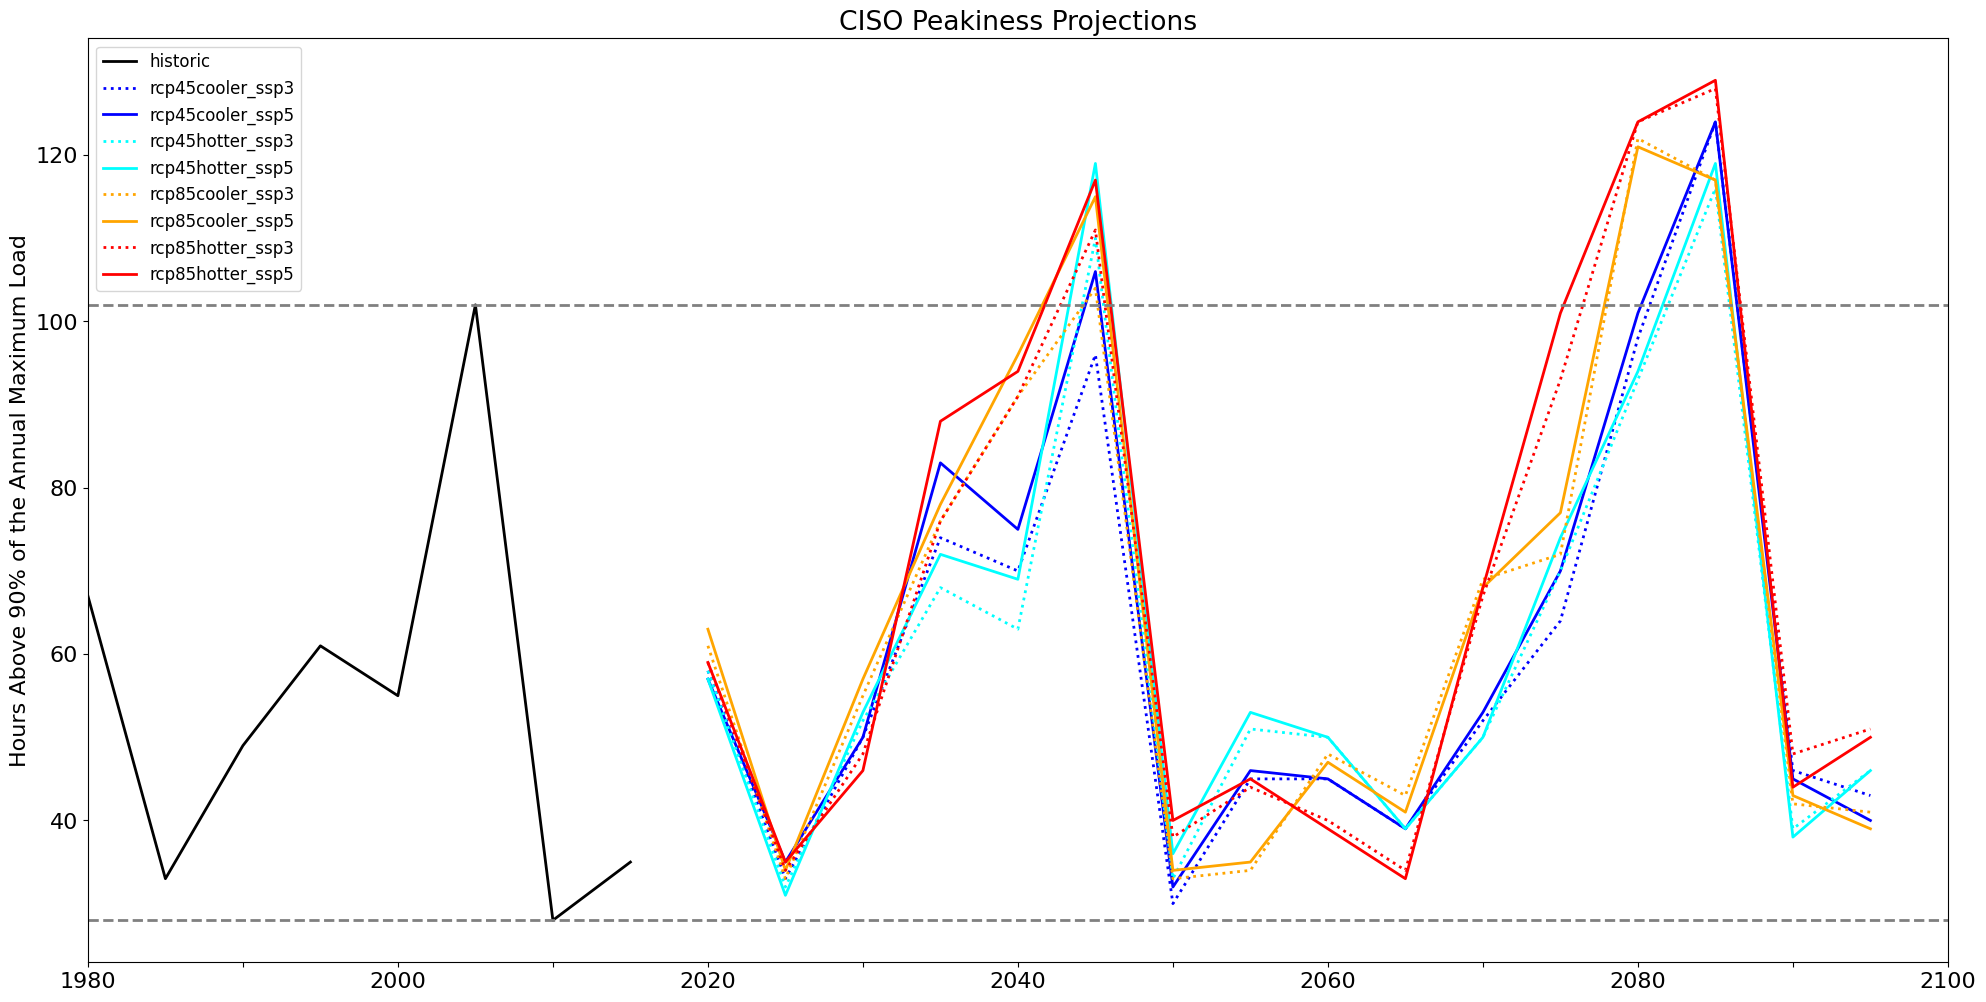

In [63]:
output_df = plot_ba_peakiness(ba_to_plot = 'CISO',
                              data_input_dir = data_input_dir,
                              data_output_dir = data_output_dir,
                              threshold = 0.9,
                              image_output_dir = image_output_dir, 
                              image_resolution = 50, 
                              save_images = False)

output_df
